In [23]:
import pandas as pd
import numpy as np

def group_timestamps(timestamps, avg_window_hours=24):
    # a list of timestamp ranges that are close to each other
    timestamp_groups = []

    # find timestamps that are within 24 hours of any other timestamp
    for i in timestamps:
        similar_timestamps = []
        for t in timestamps:
            if abs(t-i) < pd.Timedelta(hours=avg_window_hours):
                similar_timestamps.append(t)

        # remove the timestamps that are similar to the current timestamp, as they are already in the list
        for s in similar_timestamps:
            timestamps = timestamps[timestamps != s]

        if len(similar_timestamps) > 0:
            timestamp_groups.append(similar_timestamps)

    return timestamp_groups

with open('Results_210423.xlsx', 'rb') as f:
    input_df = pd.read_excel(f, sheet_name='Analytics Model - LIMS')

dashboard_data = []
output_df = pd.DataFrame()

# remove pesky trailing spaces
input_df['Tank'] = input_df['Tank'].str.rstrip()

tanks = input_df['Tank'].unique()

for t in tanks:
    # extract data relevant to current tank
    tank_df = input_df[input_df['Tank'] == t]

    timestamps = tank_df["SampleResults[Sampled Timestamp]"]

    # figure out if any timestamps are close enough to be averaged
    timestamp_groups = group_timestamps(timestamps, avg_window_hours=24)

    for g in timestamp_groups:
        # extract the data for the current timestamp group
        data_to_avg = tank_df[tank_df['SampleResults[Sampled Timestamp]'].isin(g)]

        determinands = data_to_avg['Determinand[Determinand Name]'].unique()

        for d in determinands:
            # extract the data for the current determinand
            determinand_df = data_to_avg[data_to_avg['Determinand[Determinand Name]'] == d]
            determinand_df.reset_index(drop=True, inplace=True)

            result = determinand_df['SampleResults[Sample Result]']
            unit = determinand_df['Determinand[Unit of Measure]'][0]
            sample_nums = determinand_df['SampleResults[SampleNumber]'].unique()

            # remove any < or > from the result
            result = result.str.replace("<", "")
            result = result.str.replace(">", "")
            result = pd.to_numeric(result, errors='raise')

            std_dev = result.std()
            std_dev = round(std_dev, 2)
            result = result.mean()
            result = round(result, 2)

            time = pd.Timestamp(g[0])

            # Some formatting for output

            # remove spaces from determinand
            determinand = d.replace(" ", "-")

            # add ST to tank name unless it is INLET
            tank = t
            if tank != "INLET":
                tank = f"ST{tank}"

            if len(tank) == 7:
                tank = tank.replace(" ", ".")
            if len(tank) == 6:
                tank = tank.replace(" ", "C.")

            dashboard_sample = {
                "key"    : f"{tank}.{determinand}",
                "value"  : result,
                "epoch"  : time.timestamp()
            }

            df_sample = pd.DataFrame({
                "tank"        : tank,
                "determinand" : d,
                "value"       : result,
                "std_dev"     : std_dev,
                "unit"        : unit,
                "timestamp"   : time,
                "sample_nums" : str(sample_nums)
            }, index=[0])

            dashboard_data.append(dashboard_sample)
            output_df = pd.concat([output_df, df_sample], axis=0, ignore_index=True)
print(dashboard_data)
output_df



[{'key': 'INLET.Ammonia', 'value': 16.96, 'epoch': 1680521400.0}, {'key': 'INLET.Nitrate', 'value': 1.5, 'epoch': 1680521400.0}, {'key': 'INLET.Nitrite', 'value': 0.81, 'epoch': 1680521400.0}, {'key': 'INLET.Phosphorus', 'value': 5.28, 'epoch': 1680521400.0}, {'key': 'INLET.Soluble-Chemical-Oxygen-Demand', 'value': 178.67, 'epoch': 1680521400.0}, {'key': 'INLET.Sulphate', 'value': 49.07, 'epoch': 1680521400.0}, {'key': 'INLET.Suspended-solids', 'value': 327.67, 'epoch': 1680521400.0}, {'key': 'INLET.Total-Chemical-Oxygen-Demand', 'value': 622.33, 'epoch': 1680521400.0}, {'key': 'INLET.Total-Nitrogen-(as-N)', 'value': 24.73, 'epoch': 1680521400.0}, {'key': 'INLET.Total-oxidised-nitrogen', 'value': 2.31, 'epoch': 1680521400.0}, {'key': 'INLET.Soluble-Chemical-Oxygen-Demand', 'value': 152.33, 'epoch': 1681200900.0}, {'key': 'INLET.Suspended-solids', 'value': 257.0, 'epoch': 1681200900.0}, {'key': 'INLET.Total-Chemical-Oxygen-Demand', 'value': 682.0, 'epoch': 1681200900.0}, {'key': 'INLET.

,tank,determinand,value,std_dev,unit,timestamp,sample_nums
0,INLET,Ammonia,16.96,0.39,mg/l as N,2023-04-03 11:30:00,[17319560 17319561 17319562]
1,INLET,Nitrate,1.50,0.42,mg/l as N,2023-04-03 11:30:00,[17319560 17319561 17319562]
2,INLET,Nitrite,0.81,0.13,mg/l as N,2023-04-03 11:30:00,[17319560 17319561 17319562]
3,INLET,Phosphorus,5.28,1.83,mgP/l,2023-04-03 11:30:00,[17319560 17319561 17319562]
4,INLET,Soluble Chemical Oxygen Demand,178.67,5.13,mgO₂/l,2023-04-03 11:30:00,[17319560 17319561 17319562]
...,...,...,...,...,...,...,...
551,ST20C.3,Total organic carbon,21.10,3.75,mgC/l,2023-04-24 10:00:00,[17341844 17341845 17341846]
552,ST20C.3,Total oxidised nitrogen,0.12,0.00,mg/l as N,2023-04-24 10:00:00,[17341844 17341845 17341846]
553,ST20C.3,Soluble Chemical Oxygen Demand,92.67,5.51,mgO₂/l,2023-05-02 07:45:00,[17336359 17336360 17336361]
554,ST20C.3,Suspended solids,34.00,1.00,mg/l,2023-05-02 07:45:00,[17336359 17336360 17336361]


In [ ]:
# post to dashboard http
import requests
import json

url = "https://groker.init.st/api/events"
headers = {
    "Content-Type"   : "application/json",
    "Accept-Version" : "~0",
    "X-IS-AccessKey" : "ist_O6Vp7ViKli7ozqh8cdfBGsJjCVOPGoi7",
    "X-IS-BucketKey"  : "Y6TVW65B6ULJ"
}

requests.post(url, headers=headers, data=json.dumps(dashboard_data))

In [24]:

tanks = ['STCON', 'STINS', 'ST20C', 'ST30C', 'INLET']
for t in tanks:

    # select from output_df where tank name starts with e.g. "STINS"
    tab_df = output_df[output_df['tank'].str.startswith(t)]

    # arrange so the STINS1 and STINS2 are side by side
    tab_df = tab_df.pivot_table(index=['determinand', 'unit' ], columns=['tank', 'timestamp'], values='value',)

tab_df

tank                                                   INLET  \
timestamp                                2023-04-03 11:30:00   
determinand                    unit                            
Alkalinity                     mgCaCO₃/l                 NaN   
Ammonia                        mg/l as N               16.96   
Biochemical oxygen demand      mgO₂/l                    NaN   
Conductivity                   mS/cm                     NaN   
Manganese                      mgMn/l                    NaN   
Nitrate                        mg/l as N                1.50   
Nitrite                        mg/l as N                0.81   
Phosphorus                     mgP/l                    5.28   
Soluble Chemical Oxygen Demand mgO₂/l                 178.67   
Sulphate                       mgSO₄/l                 49.07   
Suspended solids               mg/l                   327.67   
Total Chemical Oxygen Demand   mgO₂/l                 622.33   
Total Nitrogen (as N)          mg/l as N               24.73   
Total oxidised nitrogen        mg/l as N                2.31   

tank                                                          \
timestamp                                2023-04-11 08:15:00   
determinand                    unit                            
Alkalinity                     mgCaCO₃/l                 NaN   
Ammonia                        mg/l as N                 NaN   
Biochemical oxygen demand      mgO₂/l                    NaN   
Conductivity                   mS/cm                     NaN   
Manganese                      mgMn/l                    NaN   
Nitrate                        mg/l as N                 NaN   
Nitrite                        mg/l as N                 NaN   
Phosphorus                     mgP/l                     NaN   
Soluble Chemical Oxygen Demand mgO₂/l                 152.33   
Sulphate                       mgSO₄/l                   NaN   
Suspended solids               mg/l                   257.00   
Total Chemical Oxygen Demand   mgO₂/l                 682.00   
Total Nitrogen (as N)          mg/l as N                 NaN   
Total oxidised nitrogen        mg/l as N                 NaN   

tank                                                          \
timestamp                                2023-04-18 10:50:00   
determinand                    unit                            
Alkalinity                     mgCaCO₃/l                 NaN   
Ammonia                        mg/l as N               17.28   
Biochemical oxygen demand      mgO₂/l                    NaN   
Conductivity                   mS/cm                     NaN   
Manganese                      mgMn/l                    NaN   
Nitrate                        mg/l as N                1.34   
Nitrite                        mg/l as N                0.98   
Phosphorus                     mgP/l                    2.76   
Soluble Chemical Oxygen Demand mgO₂/l                  83.00   
Sulphate                       mgSO₄/l                 33.83   
Suspended solids               mg/l                   129.00   
Total Chemical Oxygen Demand   mgO₂/l                 268.67   
Total Nitrogen (as N)          mg/l as N               20.80   
Total oxidised nitrogen        mg/l as N                2.32   

tank                                                          \
timestamp                                2023-04-24 09:00:00   
determinand                    unit                            
Alkalinity                     mgCaCO₃/l              286.33   
Ammonia                        mg/l as N               36.49   
Biochemical oxygen demand      mgO₂/l                 198.67   
Conductivity                   mS/cm                    0.68   
Manganese                      mgMn/l                   0.20   
Nitrate                        mg/l as N                0.40   
Nitrite                        mg/l as N                0.02   
Phosphorus                     mgP/l                    6.09   
Soluble Chemical Oxygen Deman

In [25]:
with pd.ExcelWriter("output.xlsx") as writer:

    output_df.to_excel(writer, sheet_name="Averaged Data")
    input_df.to_excel(writer, sheet_name="Original Data")
    

    tanks = ['STCON', 'STINS', 'ST20C', 'ST30C', 'INLET']
    for t in tanks:

        # select from output_df where tank name starts with e.g. "STINS"
        tab_df = output_df[output_df['tank'].str.startswith(t)]

        # arrange so the individual tanks are shown are side by side
        tab_df = tab_df.pivot_table(index=['determinand', 'unit' ], columns=['tank', 'timestamp'], values='value')
        tab_df.to_excel(writer, sheet_name=t)

In [26]:


# # resize the columns in the excel file to fit the data, while handling merged cells

import openpyxl
from openpyxl.utils import get_column_letter
from openpyxl.styles import Alignment

wb = openpyxl.load_workbook("output.xlsx")

for ws in wb.worksheets:
    for col in ws.columns:
        max_length = 0
        try:
            column = col[0].column_letter
        except:
            column = col[1].column_letter



        for cell in col:
            cell.alignment = Alignment(wrap_text=True)
            if len(str(cell.value)) > max_length:
                max_length = len(str(cell.value))

        adjusted_width = (max_length + 2) * 1.2
        ws.column_dimensions[column].width = adjusted_width

# Tweak the format of the tank specific sheets
tanks = ['STCON', 'STINS', 'ST20C', 'ST30C', 'INLET']
for t in tanks:
    ws = wb[t]

    # set the format of row 2, columns c onwards to be a date
    for col in ws.columns:
        letter = col[1].column_letter
        if letter in ["A", "B"]:
            continue
        cell = col[1]
        cell.number_format = "mmm-dd"
        ws.column_dimensions[letter].width = 9


wb.save("output.xlsx")




In [1]:
# import initial_state_backup.csv to dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import CheckButtons
import matplotlib.dates as dates

%matplotlib widget

sensor_df = pd.read_csv("initial_state_backup.csv", names=["Timestamp", "Key", "Value"])

keys = []

for k in sensor_df["Key"].unique():
    # skip keys we don't need
    if k.startswith("feedcontrol"):
        continue
    if "tc" in k or "TEST" in k or "debug" in k:
        continue
    keys.append(k)

print(f'{keys=}')






keys=['ST30C.ts3', 'ST30C.ts2', 'ST30C.ts1', 'ST30C.tl3', 'ST30C.tl2', 'ST30C.tl1', 'ST30C.pr4', 'ST30C.pr3', 'ST30C.pr2', 'ST30C.pr1', 'ST30C.ph3', 'ST30C.ph2', 'ST30C.ph1', 'ST30C.gc4', 'STINS.ts3', 'STINS.ts2', 'STINS.ts1', 'STINS.tl3', 'STINS.tl2', 'STINS.tl1', 'STINS.pr4', 'STINS.pr3', 'STINS.pr2', 'STINS.pr1', 'STINS.ph3', 'STINS.ph2', 'STINS.ph1', 'STINS.gc4', 'STINS.gc3', 'STCON.ts4', 'STCON.ts3', 'STCON.ts2', 'STCON.ts1', 'STCON.tl3', 'STCON.tl2', 'STCON.tl1', 'STCON.pr4', 'STCON.pr3', 'STCON.pr2', 'STCON.pr1', 'STCON.ph3', 'STCON.ph2', 'STCON.ph1', 'STCON.gc4', 'STCON.gc3', 'ST30C.gc3', 'ST20C.ts3', 'ST20C.ts2', 'ST20C.ts1', 'ST20C.tl3', 'ST20C.tl2', 'ST20C.tl1', 'ST20C.pr4', 'ST20C.pr3', 'ST20C.pr2', 'ST20C.pr1', 'ST20C.ph3', 'ST20C.ph2', 'ST20C.ph1', 'ST20C.gc4', 'ST20C.gc3', 'ST20C.gc2', 'STINS.gc2', 'STCON.gc2', 'ST30C.gc2', 'ST20C.gc1', 'STINS.gc1', 'STCON.gc1', 'ST30C.gc1']


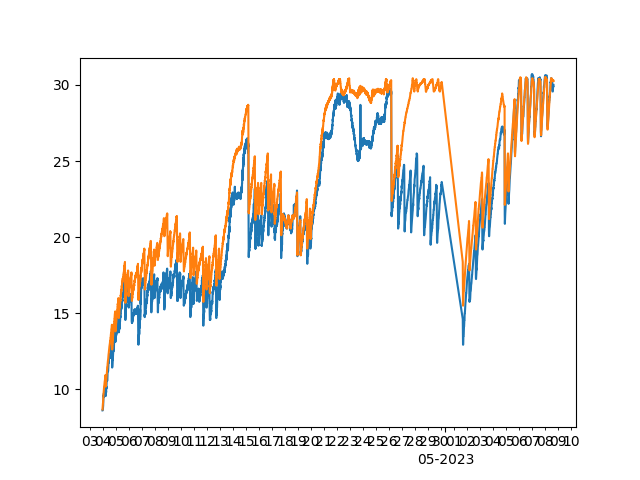

In [2]:
# create a matplotlib figure

fig, ax = plt.subplots()

labels = []
lines = []

for k in [keys[0],keys[1]]:

    key_df = sensor_df[sensor_df["Key"] == k].copy()

# line, = ax.plot(key_df["Timestamp"], key_df["Value"], label=k)

    key_df.reset_index(inplace=True)
    key_df.sort_values(by="Timestamp", inplace=True)
    # key_df.plot(x="Timestamp", y="Value", label=k)

    key_df['Timestamp'] = pd.to_datetime(key_df['Timestamp'])

    x = key_df["Timestamp"]
    y = key_df["Value"]



    ax.plot(x, y)
ax.xaxis.set_minor_locator(dates.HourLocator(interval=24))   # every 4 hours
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d'))  # hours and minutes
ax.xaxis.set_major_locator(dates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('\n%m-%Y')) 


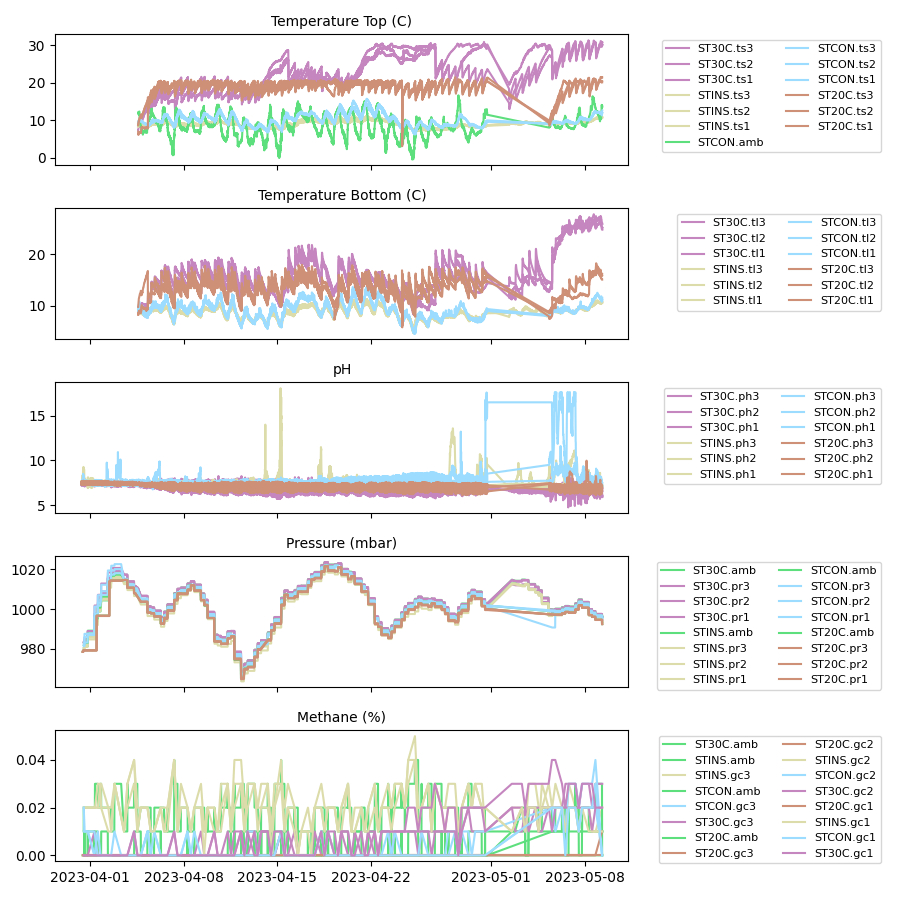

In [98]:
# Create an interactive plot with a checkbox for each key and zoomable x axis

fig, ax = plt.subplots(5, sharex=True, figsize=(9, 9))

labels = []
lines = []
lined = {}  # Will map legend lines to original lines.

subplot_dict = {
    "ts": [ax[0],"Temperature Top (C)"],
    "tl": [ax[1],"Temperature Bottom (C)"],
    "ph": [ax[2],"pH"],
    "pr": [ax[3],"Pressure (mbar)"],
    "gc": [ax[4],"Methane (%)"],
}

color_dict = {
    "ST30C": "#c586c0",
    "ST20C": "#ce9178",
    "STINS": "#dcdcaa",
    "STCON": "#9cdcfe",
    "AMBNT": "#5edf7e"
}

for s in subplot_dict.values():
    ax = s[0]
    ax.labelslist = []
    ax.lineslist = []
    ax.set_title(s[1], fontsize=10)

plt.tight_layout()

for s in subplot_dict.values():
    ax = s[0]
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])

# for k in [keys[0],keys[1]]:
for k in keys:
# for k in keys[:30]:

    key_df = sensor_df[sensor_df["Key"] == k].copy()
    key_df.reset_index(inplace=True)
    key_df.sort_values(by="Timestamp", inplace=True)
    key_df['Timestamp'] = pd.to_datetime(key_df['Timestamp'])
    x = key_df["Timestamp"]
    y = key_df["Value"]

    color = None
    for c in color_dict.keys():
        if c in k:
            color = color_dict[c]
            break

    subplot = None
    for s in subplot_dict.keys():
        if s in k:
            subplot = subplot_dict[s][0]
            break

    if "4" in k:
        k = k[:-3]+"amb"
        color = color_dict["AMBNT"]

    if color is None:
        print(f"could not find a color match for key {k}, check the color_dict")

    if subplot is None:
        print(f"could not find a subplot match for key {k}, check the subplot_dict")

    line, = subplot.plot(x, y, label=k)
    line.set_color(color)


    subplot.lineslist.append(line)
    subplot.labelslist.append(k)

for s in subplot_dict.values():
    ax = s[0]
    legend = ax.legend(bbox_to_anchor=(1.45, 1), ncol=2, fontsize="8", loc="upper right")

    for legline, origline in zip(legend.get_lines(), ax.lineslist):
        legline.set_picker(True)  # Enable picking on the legend line.
        legline.pickradius = 10
        lined[legline] = origline


def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend, so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)
plt.show()

In [ ]:
key_df["Timestamp"]
key_df["Value"]

In [81]:
k = "STCON.pr4"

k = k[:-3]+"amb"

k



'STCON.amb'

In [5]:
for k in keys:
    if "ts" in k:
        print(k)


ST30C.ts3
ST30C.ts2
ST30C.ts1
STINS.ts3
STINS.ts2
STINS.ts1
STCON.ts4
STCON.ts3
STCON.ts2
STCON.ts1
ST20C.ts3
ST20C.ts2
ST20C.ts1
